In [1]:
!pip install tensorflow==2.2
!pip install keras

try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

  Could not find a version that satisfies the requirement tensorflow==2.2 (from versions: 0.12.0rc0, 0.12.0rc1, 0.12.0, 0.12.1, 1.0.0, 1.0.1, 1.1.0rc0, 1.1.0rc1, 1.1.0rc2, 1.1.0, 1.2.0rc0, 1.2.0rc1, 1.2.0rc2, 1.2.0, 1.2.1, 1.3.0rc0, 1.3.0rc1, 1.3.0rc2, 1.3.0, 1.4.0rc0, 1.4.0rc1, 1.4.0, 1.4.1, 1.5.0rc0, 1.5.0rc1, 1.5.0, 1.5.1, 1.6.0rc0, 1.6.0rc1, 1.6.0, 1.7.0rc0, 1.7.0rc1, 1.7.0, 1.7.1, 1.8.0rc0, 1.8.0rc1, 1.8.0, 1.9.0rc0, 1.9.0rc1, 1.9.0rc2, 1.9.0, 1.10.0rc0, 1.10.0rc1, 1.10.0, 1.10.1, 1.11.0rc0, 1.11.0rc1, 1.11.0rc2, 1.11.0, 1.12.0rc0, 1.12.0rc1, 1.12.0rc2, 1.12.0, 1.12.2, 1.12.3, 1.13.0rc0, 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 2.0.0a0, 2.0.0b0, 2.0.0b1)
No matching distribution found for tensorflow==2.2
    100% |████████████████████████████████| 2.8MB 273kB/s ta 0:00:01
    100% |████████████████████████████████| 583kB 751kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/3a/5f/47e578b3ae79e2624e205445ab77a1848acdaa2929a00eeef6b16ea

/home/rathin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rathin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rathin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rathin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
  digit_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs, y = create_pairs(images, digit_indices)
  y = y.astype('float32')
  return pairs, y


def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

In [3]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4423680/4422102 [==============================] - 6s 1us/step


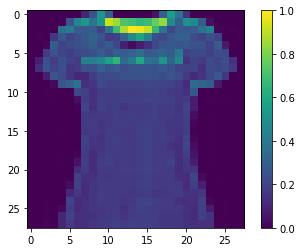

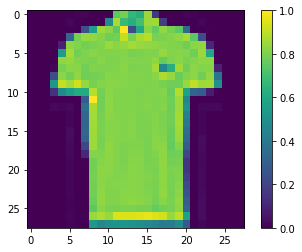

1.0


In [4]:
# array index
this_pair = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

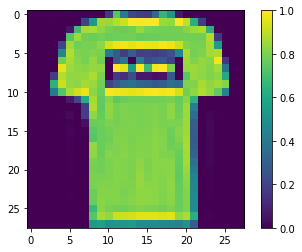

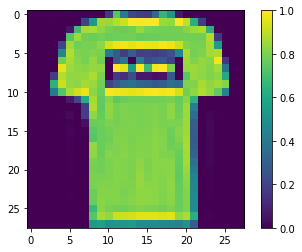

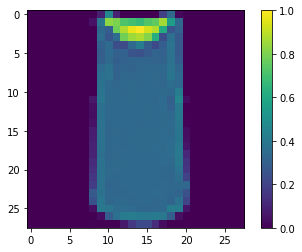

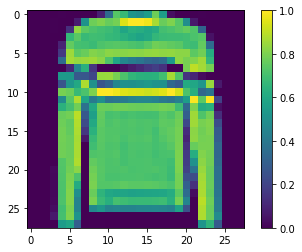

In [5]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

In [6]:
def initialize_base_network():
  input = Input(shape=(28,28,), name="base_input")
  x = Flatten(name="flatten_input")(input)
  x = Dense(128, activation='relu', name="first_base_dense")(x)
  x = Dropout(0.1, name="first_dropout")(x)
  x = Dense(128, activation='relu', name="second_base_dense")(x)
  x = Dropout(0.1, name="second_dropout")(x)
  x = Dense(128, activation='relu', name="third_base_dense")(x)

  return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [7]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [8]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [9]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
      '''Contrastive loss from Hadsell-et-al.'06
      http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
      '''
      square_pred = K.square(y_pred)
      margin_square = K.square(K.maximum(margin - y_pred, 0))
      return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [10]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Train on 119980 samples, validate on 19980 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
119980/119980 [==============================] - 11s 94us/sample - loss: 0.1117 - val_loss: 0.0830
Epoch 2/20
119980/119980 [==============================] - 7s 60us/sample - loss: 0.0803 - val_loss: 0.0757
Epoch 3/20
119980/119980 [==============================] - 7s 57us/sample - loss: 0.0722 - val_loss: 0.0705
Epoch 4/20
119980/119980 [==============================] - 7s 60us/sample - loss: 0.0672 - val_loss: 0.0663
Epoch 5/20
119980/119980 [==============================] - 7s 58us/sample - loss: 0.0641 - val_loss: 0.0664
Epoch 6/20
119980/119980 [==============================] - 7s 59us/sample - loss: 0.0621 - val_loss: 0.0669
Epoch 7/20
119980/119980 [==============================] - 7s 58us/sample - loss: 0.0605 - val_loss: 0.0658
Epoch 8/20
119980/119980 [==============================] - 7s 59us/sample - loss: 0.0587 -

In [11]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [12]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

19980/19980 [==============================] - 1s 48us/sample - loss: 0.0638
Loss = 0.06376186300263002, Train Accuracy = 0.9366561093515586 Test Accuracy = 0.9131131131131132


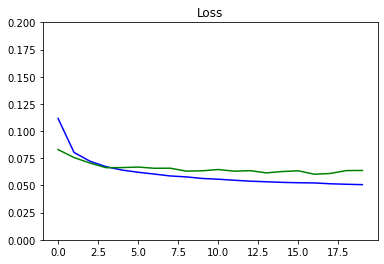

In [13]:
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)